# Inversion of Frequency Domain Electromagnetic Data at Bookpurnong 

<img src="https://em.geosci.xyz/_images/booky-location.jpg" width=70%>

https://em.geosci.xyz/content/case_histories/bookpurnong/index.html

Lindsey J. Heagy, Rowan Cockett, Seogi Kang, Gudni K. Rosenkjaer, Douglas W. Oldenburg, A framework for simulation and inversion in electromagnetics, Computers & Geosciences, Volume 107, 2017, Pages 1-19, ISSN 0098-3004, http://dx.doi.org/10.1016/j.cageo.2017.06.018.

In [1]:
import dask
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.constants import mu_0
from scipy.spatial import cKDTree
import ipywidgets

import discretize
from pymatsolver import Pardiso
from SimPEG import (
    data, maps, utils,
    data_misfit, regularization,
    optimization,
    inversion, inverse_problem,
    directives,
)
from SimPEG.electromagnetics import frequency_domain as fdem

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 14

## Load and plot the data

In [3]:
data_directory = "bookpurnong-data"

In [4]:
# Load resolve data
resolve = h5py.File(os.path.sep.join([data_directory, "booky_resolve.hdf5"]), "r")

river_path = resolve["river_path"][()]  # River path
n_sounding = resolve["data"].shape[0]  # the # of soundings

# Bird height from surface
height_resolve = resolve["src_elevation"][()]

# fetch the frequencies we are considering
cpi_inds = [0, 2, 6, 8, 10]  # Indices for HCP in-phase
cpq_inds = [1, 3, 7, 9, 11]  # Indices for HCP quadrature
frequencies = resolve["frequency_cp"][()]

In [5]:
# plot observed and predicted data
def plot_data(frequency_index=0, sounding_index=40):

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    for i, a in enumerate(ax): 
        out = utils.plot2Ddata(
            resolve["xy"][:, :],
            resolve["data"][:, 2*frequency_index+i],
            ncontour=100,
            ax=a,
            
        )
        a.plot(resolve["xy"][:, 0], resolve["xy"][:, 1], 'k.', ms="2")
        a.plot(resolve["xy"][sounding_index, 0], resolve["xy"][sounding_index, 1], 'w.', ms="8")
        cb = plt.colorbar(out[0], ax=a)
        cb.set_label("$bz$ (ppm)")

        header = str(resolve["data_header"][2*frequency_index + i])
        title = f"{header[5:-3]}Hz {'real' if header[4] == 'I' else 'imag'}"
        a.set_title(title)

        a.plot(river_path[:, 0], river_path[:, 1], "k-", lw=0.5)
        a.set_aspect(1)

        a.set_xlabel("easting (m)")
        a.set_ylabel("northing (m)")
    plt.tight_layout()

In [6]:
ipywidgets.interact(
    plot_data, 
    frequency_index=ipywidgets.IntSlider(min=0, max=len(cpi_inds), value=0),
    sounding_index=ipywidgets.IntSlider(min=0, max=n_sounding, value=517)
)

interactive(children=(IntSlider(value=0, description='frequency_index', max=5), IntSlider(value=517, descripti…

<function __main__.plot_data>

In [7]:
# survey parameters
rx_offset = 7.86  # tx-rx separation
bp = -mu_0 / (4 * np.pi * rx_offset ** 3)  # primary magnetic field

In [8]:
def resolve_1Dinversions(
    serialized_mesh,
    dobs,
    src_height,
    frequencies,
    sigma_0,
    relative_error=0.08,
    floor=1e-14,
    rx_offset=7.86,
    beta=2.0,
    alpha_s=1e-3,
    alpha_x=1.0
    
):
    from pyMKL import mkl_set_num_threads
    mkl_set_num_threads(1)
    # ------------------- Mesh -------------------------------- #
    mesh = discretize.CylMesh.deserialize(serialized_mesh)
    
    # ------------------- Model & Mappings --------------------- #
    
    sigma_air = 1e-8
    active = mesh.vectorCCz < 0.0
    actMap = maps.InjectActiveCells(mesh, active, np.log(sigma_air), nC=mesh.nCz)
    mapping = maps.ExpMap(mesh) * maps.SurjectVertical1D(mesh) * actMap
    m0 = np.log(sigma_0) * np.ones(active.sum())  # starting model

    # ------------------- Forward Simulation ------------------- #
    # set up the receivers
    receiver_list = [
        fdem.receivers.PointMagneticFluxDensitySecondary(
            np.array([[rx_offset, 0.0, src_height]]), orientation="z", component=component
        )
        for component in ["real", "imag"]
    ]

    # source location
    source_location = np.array([0.0, 0.0, src_height])
    source_list = [
        fdem.sources.MagDipole(receiver_list, frequency, source_location, orientation="z") 
        for frequency in frequencies
    ]

    # construct a forward simulation
    survey = fdem.Survey(source_list=source_list)
    survey._sourceOrder = dict()  # todo- this is a bug
    [survey._sourceOrder.setdefault(src._uid, ii) for ii, src in enumerate(source_list)]
    
    simulation = fdem.Simulation3DMagneticFluxDensity(
        mesh, sigmaMap=mapping, solver=Pardiso
    )
    simulation.survey = survey

    # ------------------- Inversion ------------------- #
    # data misfit term
    uncertainty = abs(dobs) * relative + floor
    observed_data = data.Data(survey=survey, dobs=dobs, standard_deviation=uncertainty)
    dmisfit = data_misfit.L2DataMisfit(simulation=simulation, data=observed_data)

    # regularization
    regularization_mesh = discretize.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
    reg = regularization.Simple(regularization_mesh, alpha_s=alpha_s, alpha_x=alpha_x)

    # optimization
    opt = optimization.InexactGaussNewton(maxIter=10)

    # statement of the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmisfit, reg, opt, beta=beta)

    # Inversion directives and parameters
    target = directives.TargetMisfit()
    inv = inversion.BaseInversion(inv_prob, directiveList=[target])

    # run the inversion
    mopt = inv.run(m0)
    return mopt, inv_prob.dpred, observed_data.dobs


## A single sounding

In [9]:
sounding_index = 517

In [10]:
cs, ncx, ncz, npad = 1., 10., 10., 20
pf = 1.3
hx = [(cs, ncx), (cs, npad,pf)]
npadz = 12
hz = np.logspace(np.log10(1.0), np.log10(12.0), npad-1)
hz_pad = hz[-1] * pf ** np.arange(npadz)
hz = np.r_[hz_pad[::-1], hz[::-1], hz, hz_pad]
mesh = discretize.CylMesh([hx, 1, hz], "00C")
active = mesh.vectorCCz < 0.0

In [11]:
# build starting and reference model
sigma_half = 1e-1

# set up a noise model
# 10% for the 3 lowest frequencies, 15% for the two highest
relative = np.repeat(np.r_[np.ones(3) * 0.1, np.ones(2) * 0.15], 2)
floor = abs(20 * bp * 1e-6)  # floor of 20ppm

In [13]:
dobsi = (
    np.c_[
        resolve["data"][sounding_index, :][cpi_inds].astype(float),
        resolve["data"][sounding_index, :][cpq_inds].astype(float),
    ].flatten()
    * bp
    * 1e-6
)

# perform the inversion
src_height = height_resolve[sounding_index].astype(float)
result = resolve_1Dinversions(
    mesh.serialize(),
    dobsi,
    src_height,
    frequencies,
    sigma_0=sigma_half,
    relative_error=relative,
    floor=floor,
)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+00  1.07e+02  0.00e+00  1.07e+02    2.27e+01      0              
   1  2.00e+00  1.09e+01  2.25e+00  1.54e+01    8.15e+00      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.0823e+01
0 : |xc-x_last| = 1.8484e+01 <= tolX*(1+|x0|) = 1.3820e+00
0 : |proj(x-g)-x|    = 8.1485e+00 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 8.1485e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      2
---------------

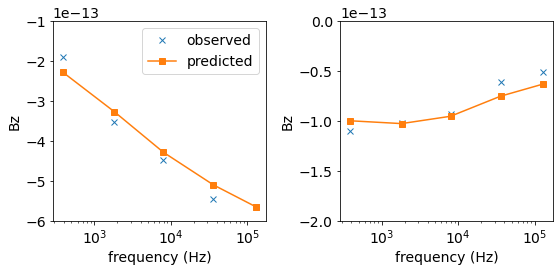

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].semilogx(frequencies, result[2][::2], "x", label="observed")
ax[0].semilogx(frequencies, result[1][::2], "-s", label="predicted")
ax[0].set_ylim([-6e-13, -1e-13])

ax[1].semilogx(frequencies, result[2][1::2], "x")
ax[1].semilogx(frequencies, result[1][1::2], "-s")
ax[1].set_ylim([-2e-13, 0])

ax[0].legend()

for a, t in zip(ax, ["real", "imag"]):
    a.set_xlabel("frequency (Hz)")
    a.set_ylabel("Bz")
plt.tight_layout()

(-250.0, 0.0)

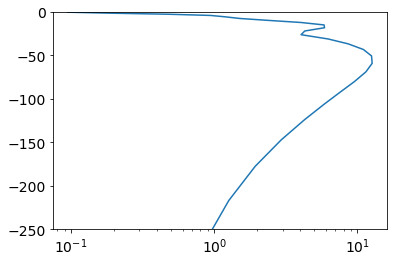

In [15]:
fig, ax = plt.subplots(1, 1)
ax.semilogx(np.exp(result[0]), mesh.vectorCCz[active])
ax.set_ylim([-250, 0])


## Invert the whole survey

In [16]:
from dask_jobqueue import PBSCluster
cores = 12
cluster = PBSCluster(
    queue='regular', 
    project="UCLB0022", 
    cores=cores,
    processes=cores,
    memory="109GB"
)
cluster.scale(jobs=10)

/glade/u/home/heagy/.conda/envs/bookpurnong-inversion/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [17]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.148.10.15:45819 Dashboard: https://jupyterhub.ucar.edu/ch/user/heagy/proxy/38323/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [18]:
# loop over the soundings and invert each
# initalize empty lists for storing inversion results
mopt = []  # recovered model
dpred = []  # predicted data
dobs = []  # observed data

for rxind in range(n_sounding):

    # convert data from ppm to magnetic field (A/m^2)
    dobsi = (
        np.c_[
            resolve["data"][rxind, :][cpi_inds].astype(float),
            resolve["data"][rxind, :][cpq_inds].astype(float),
        ].flatten()
        * bp
        * 1e-6
    )

    # perform the inversion
    src_height = height_resolve[rxind].astype(float)
    result = dask.delayed(resolve_1Dinversions)(
        mesh.serialize(),
        dobsi,
        src_height,
        frequencies,
        sigma_0=sigma_half,
        relative_error=relative,
        floor=floor,
    )

    mopt.append(result[0])
    dpred.append(result[1])
    dobs.append(result[2])

In [19]:
%%time
out = dask.compute(mopt, dpred, dobs);

CPU times: user 30 s, sys: 1.14 s, total: 31.2 s
Wall time: 1min 31s


In [20]:
mopt = np.vstack(out[0])
dpred = np.vstack(out[1])
dobs = np.vstack(out[2])

# Compare predicted and observed data 

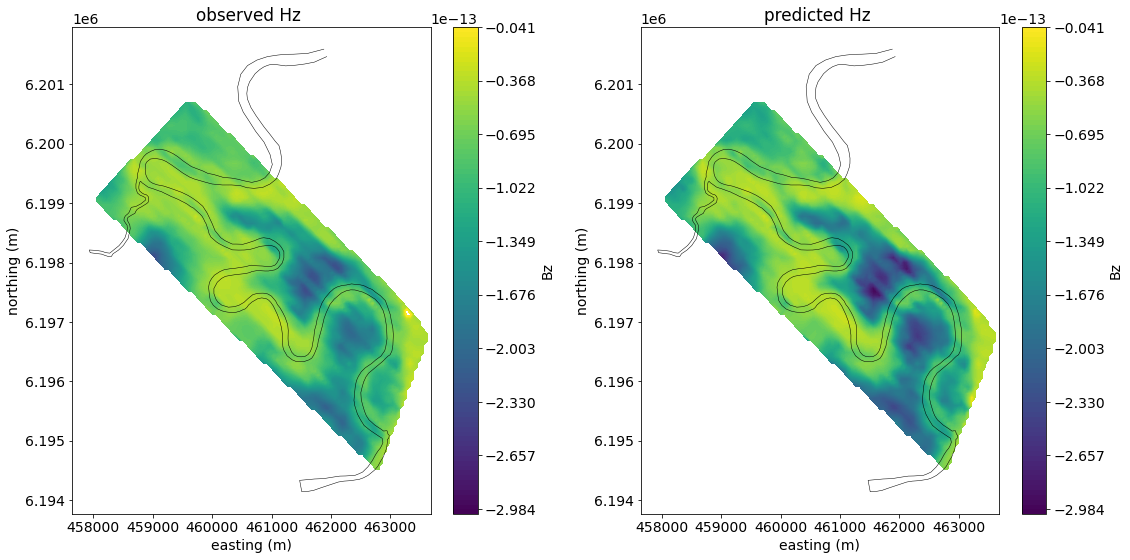

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

frequency_index = 0

for a, d, t in zip(ax, [dobs, dpred], ["observed", "predicted"]): 

    out = utils.plot2Ddata(
        resolve["xy"][()],
        d[:, frequency_index],
        ncontour=100,
        ax=a,
        contourOpts={"cmap": "viridis", "vmin":dpred[:, frequency_index].min(), "vmax":dpred[:, frequency_index].max()},
    )
    vmin, vmax = out[0].get_clim()
    cb = plt.colorbar(out[0], ax=a)
    cb.set_label("Bz")
    
    title = f"{t} Hz "
    a.set_title(title)

    a.plot(river_path[:, 0], river_path[:, 1], "k-", lw=0.5)
    a.set_aspect(1)

    a.set_xlabel("easting (m)")
    a.set_ylabel("northing (m)")

plt.tight_layout()

# View the result

In [24]:
sigma = np.exp(mopt)
indz = -7  # depth index

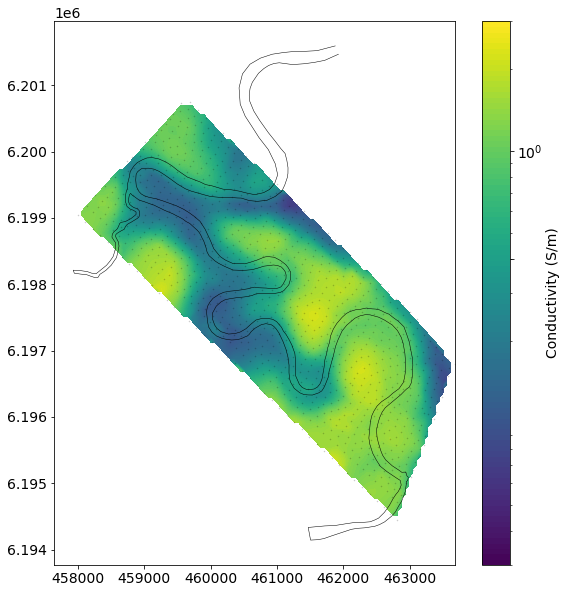

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


# interpolate to grid
tree = cKDTree(list(zip(resolve["xy"][:, 0], resolve["xy"][:, 1])))
d, d_inds = tree.query(list(zip(resolve["xy"][:, 0], resolve["xy"][:, 1])), k=20)
w = 1.0 / (d + 100.0) ** 2.0
w = utils.sdiag(1.0 / np.sum(w, axis=1)) * (w)


xy = resolve["xy"]
plot_sigma = (sigma[:, indz].flatten()[d_inds] * w).sum(axis=1)

out = utils.plot2Ddata(
    xy,
    plot_sigma,
    ncontour=100,
    scale="log",
    dataloc=False,
    contourOpts={"cmap": "viridis", "vmin": 3e-2, "vmax": 3e0},
    ax=ax,
)
ax.plot(resolve["xy"][:, 0], resolve["xy"][:, 1], "k.", alpha=0.2, ms=1)

cb = plt.colorbar(out[0], ax=ax, ticks=np.linspace(-2, 1, 6))
cb.set_label("Conductivity (S/m)")
ax.plot(river_path[:, 0], river_path[:, 1], "k-", lw=0.5)